# Project Task (Deep Learning) - Group 1

The point of the project is to learn more about the deep hedging approach and variants.

In principle the hedge $H_t = H_t(X_t)$ is learned as a function from its input variable(s) $X_t$ separately for every time point $t$. Its output is one number per traded asset and it shows the number of risky assets to be held. In the most simple set up we used the price of a single traded asset as input and the number to be held as output.

## Group 1 (Transaction costs):

This modification points at the valuation of a strategy $(V_0,H)$. Recall that the terminal wealth of a trading strategy $H$ with initial wealth $V_0$ is given by:
$$V_T = V_0 + \sum_t H_t\Delta S_t.$$
That is, the terminal wealth is the initial wealth plus the traiding gains. If there are additional costs these must be factored in and this will be reflected by modifying the terminal wealth by the accumulated cost $C_T$:
$$V_T = V_0 + \sum_t H_t\Delta S_t - C_t$$
We will model $C_{t+1}:= C_t + a|H_{t+1} - H_t|$ for some given and known number $a>0$. This means that changes in the portfolio (buying or selling) produce some ammount of additional costs.

For simplicity, we will use the *Black-Scholes* model $dS_t = \mu S_tdt + \sigma S_tdW_t$ as a price model for the risky asset, we want to hedge a European call with payoff function $f(x) = \max\{0,x-K\}$ at maturity $T>0$.

I suggest to use the parameter specifications:
$$S_0 = 100, K = 100, T=2, \sigma = 0.2, \mu = 0.08, a\in [0,1]$$
and we use a discretisation to $N=20$ time steps. 

### Create a python script that simulates paths for this model (create $P$ and $Q$ samples).

In [1]:
import numpy as np
import pandas as pd
import statistics
import tensorflow as tf
from keras.layers import Input, Dense, Subtract, Multiply, Lambda, Add
from keras.models import Model
from keras import initializers
import keras.backend as K
import matplotlib.pyplot as plt
import scipy.stats as scipy

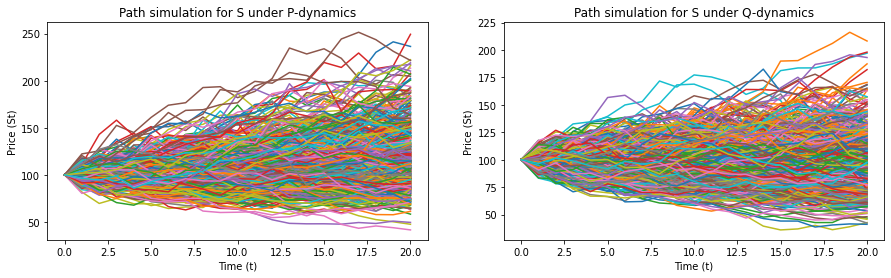

In [3]:
# Trajectories of the Black scholes model
N = 20 # time disrectization
S0 = 100 # initial value of the asset
strike = 100 # strike for the call option
T = 2 # maturity
sigma = 0.2 # volatility in Black Scholes
mu = 0.08 ## P-dynamics
#mu = 0 ## Q-dynamics
R = 500 # number of Trajectories

# Normalising initial value of S0 to 1 (1 unit of money = price of S0)
strike = strike/S0
S0 = 1

def path(S0, mu, sigma, N, T, R):
    dt = T/N
    S = np.zeros((N+1, R), np.float64) + S0
    for j in range(N):
        Z = np.random.normal(0, 1, R)
        increment = np.exp((mu - 0.5*sigma**2)*dt + sigma* np.sqrt(dt)*Z)
        S[j+1,:] = S[j,:]*increment
    return S

# Example of simulations
S_P = path(S0, mu, sigma, N, T, R)
S_Q = path(S0, 0, sigma, N, T, R)

plt.rcParams['figure.figsize'] = [15, 4]
plt.subplot(1, 2, 1)
plt.plot(S_P*100, '-')
plt.title("Path simulation for S with P-dynamics")
plt.xlabel('Time (t)')
plt.ylabel('Price (St)')

plt.subplot(1, 2, 2)
plt.plot(S_Q*100, '-')
plt.title("Path simulation for S with Q-dynamics")
plt.xlabel('Time (t)')
plt.ylabel('Price (St)')
plt.show()

### Create a deep hedging setup with $V_0 = V_0(S_0)$ and $H_t = H_t(S_t)$ incorporating the effect of $a$.

In [4]:
# Definition of neural networks function for computing heding strategies
def Deephedge(activator, a=0):
    m = 1 # dimension of price
    d = 2 # number of layers in strategy
    n = 64 # nodes in the first but last layers

    # Architecture of the network --- expecting a price path
    # Reading initial price of the risky asset. 'price' stands for current price.
    price = Input(shape=(m,))
    # Recording the initial price to the input struture 'inputs'
    inputs = [price]
    # Recording the initial strategy and costs equal to zero
    strategy_prev = 0
    costs = 0

    # The starting wealth
    wealth = Dense(1, activation='linear', trainable=True)(price)

    ## Creating position size and new wealth from current wealth and new asset price
    for j in range(N):
        pricenew = Input(shape=(m,))   # Reading new price
        inputs = inputs + [pricenew]   # Writing new price to the inputs record
        priceshift = Subtract()([pricenew, price])  # Price shift
        ## Creating architecture for the traiding strategy
        for i in range(d):
            ## Choose a layer type
            if i < d-1:
                nodes = n
                layer = Dense(nodes, activation=activator,trainable=True,
                          kernel_initializer=initializers.RandomNormal(0,1),#kernel_initializer='random_normal',
                          bias_initializer='random_normal',
                          name=str(i)+str(j))
            else:
                nodes = m
                layer = Dense(nodes, activation='linear', trainable=True,
                              kernel_initializer=initializers.RandomNormal(0,1),#kernel_initializer='random_normal',
                              bias_initializer='random_normal',
                              name=str(i)+str(j))
            # First layer depends on current price (not newprice)
            if i == 0:
                strategy = layer(price)
            else:
                strategy = layer(strategy)
            
        ## Calculating the accumulated cost
        strategyshift = abs(strategy - strategy_prev) # = |H_t - H_{t-1}|
        costs = costs - a*strategyshift # = C_{t-1} - a*|H_t - H_{t-1}|
        strategy_prev = strategy
        ## Calculating trading gains
        gains = Multiply()([strategy,priceshift])
        ## Calculating new wealth
        wealth = Add()([wealth,gains,costs])  ## current wealth + gains - costs = newwealth
        ## Setting the next price to be the current price for the next iteration
        price = pricenew
    ## Producing the terminal payoff
    payoff = Lambda(lambda x : 0.5*(K.abs(x-strike)+x-strike))(price) 
    outputs = Subtract()([payoff,wealth]) # payoff minus terminal wealth

    ## Defining the model: inputs -> outputs
    model_hedge = Model(inputs=inputs, outputs=outputs)

    return model_hedge
    

### Train your model to a test set of sample paths (which activation function works best? relu, tanh?)

#### i) Tangens hyperbolicus

First, let us try our deep hedging algorithm with the hiperbolic activation function (tanh).

In [13]:
# NN train and test parameters
a = 0.01 # costs factor
activator = "tanh"
Ktrain = 20000 # Size of training data
Ktest = 1000 # Size of test data
epochs = 15

trainpaths = path(S0, mu, sigma, N, T, Ktrain) # P-dynamics
    
## Shaping to input architecture
xtrain = []
for i in range(N+1):
    xtrain = xtrain + [trainpaths[i,:]]

# ytrain is filled with zeros
ytrain = np.zeros((Ktrain,1))

model_hedge = Deephedge(activator, a)
model_hedge.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_22 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 00 (Dense)                     (None, 64)           128         ['input_22[0][0]']               
                                                                                                  
 input_23 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 10 (Dense)                     (None, 1)            65          ['00[0][0]']                     
                                                                                            

                                                                                                  
 tf.math.subtract_43 (TFOpLambd  (None, 1)           0           ['tf.math.subtract_41[0][0]',    
 a)                                                               'tf.math.multiply_21[0][0]']    
                                                                                                  
 subtract_23 (Subtract)         (None, 1)            0           ['input_25[0][0]',               
                                                                  'input_24[0][0]']               
                                                                                                  
 tf.math.multiply_22 (TFOpLambd  (None, 1)           0           ['tf.math.abs_22[0][0]']         
 a)                                                                                               
                                                                                                  
 tf.math.a

 a)                                                               'tf.math.multiply_24[0][0]']    
                                                                                                  
 subtract_26 (Subtract)         (None, 1)            0           ['input_28[0][0]',               
                                                                  'input_27[0][0]']               
                                                                                                  
 tf.math.multiply_25 (TFOpLambd  (None, 1)           0           ['tf.math.abs_25[0][0]']         
 a)                                                                                               
                                                                                                  
 tf.math.abs_26 (TFOpLambda)    (None, 1)            0           ['tf.math.subtract_52[0][0]']    
                                                                                                  
 tf.math.s

 subtract_29 (Subtract)         (None, 1)            0           ['input_31[0][0]',               
                                                                  'input_30[0][0]']               
                                                                                                  
 tf.math.multiply_28 (TFOpLambd  (None, 1)           0           ['tf.math.abs_28[0][0]']         
 a)                                                                                               
                                                                                                  
 tf.math.abs_29 (TFOpLambda)    (None, 1)            0           ['tf.math.subtract_58[0][0]']    
                                                                                                  
 tf.math.subtract_60 (TFOpLambd  (None, 1)           0           ['110[0][0]',                    
 a)                                                               '19[0][0]']                     
          

                                                                                                  
 tf.math.multiply_31 (TFOpLambd  (None, 1)           0           ['tf.math.abs_31[0][0]']         
 a)                                                                                               
                                                                                                  
 tf.math.abs_32 (TFOpLambda)    (None, 1)            0           ['tf.math.subtract_64[0][0]']    
                                                                                                  
 tf.math.subtract_66 (TFOpLambd  (None, 1)           0           ['113[0][0]',                    
 a)                                                               '112[0][0]']                    
                                                                                                  
 114 (Dense)                    (None, 1)            65          ['014[0][0]']                    
          

 a)                                                                                               
                                                                                                  
 tf.math.abs_35 (TFOpLambda)    (None, 1)            0           ['tf.math.subtract_70[0][0]']    
                                                                                                  
 tf.math.subtract_72 (TFOpLambd  (None, 1)           0           ['116[0][0]',                    
 a)                                                               '115[0][0]']                    
                                                                                                  
 117 (Dense)                    (None, 1)            65          ['017[0][0]']                    
                                                                                                  
 018 (Dense)                    (None, 64)           128         ['input_40[0][0]']               
          

                                                                                                  
 add_36 (Add)                   (None, 1)            0           ['add_35[0][0]',                 
                                                                  'multiply_36[0][0]',            
                                                                  'tf.math.subtract_73[0][0]']    
                                                                                                  
 multiply_37 (Multiply)         (None, 1)            0           ['117[0][0]',                    
                                                                  'subtract_38[0][0]']            
                                                                                                  
 tf.math.subtract_75 (TFOpLambd  (None, 1)           0           ['tf.math.subtract_73[0][0]',    
 a)                                                               'tf.math.multiply_37[0][0]']    
          

In [14]:
model_hedge.compile(optimizer='adam',loss='mean_squared_error')
model_hedge.fit(x=xtrain,y=ytrain, epochs=epochs,verbose=True,batch_size=100)

Epoch 1/15
200/200 [==============================] - 2s 3ms/step - loss: 3.1886
Epoch 2/15
200/200 [==============================] - 1s 3ms/step - loss: 0.0856
Epoch 3/15
200/200 [==============================] - 1s 3ms/step - loss: 0.0447
Epoch 4/15
200/200 [==============================] - 1s 3ms/step - loss: 0.0330
Epoch 5/15
200/200 [==============================] - 1s 3ms/step - loss: 0.0261
Epoch 6/15
200/200 [==============================] - 1s 3ms/step - loss: 0.0213
Epoch 7/15
200/200 [==============================] - 1s 3ms/step - loss: 0.0168
Epoch 8/15
200/200 [==============================] - 1s 3ms/step - loss: 0.0133
Epoch 9/15
200/200 [==============================] - 1s 3ms/step - loss: 0.0117
Epoch 10/15
200/200 [==============================] - 1s 3ms/step - loss: 0.0106
Epoch 11/15
200/200 [==============================] - 1s 3ms/step - loss: 0.0097
Epoch 12/15
200/200 [==============================] - 1s 3ms/step - loss: 0.0090
Epoch 13/15
200/200 [====

### Model Evaluation

Performance of discretised BS-delta-hedge inside BS-model. There is only discretisation error here.


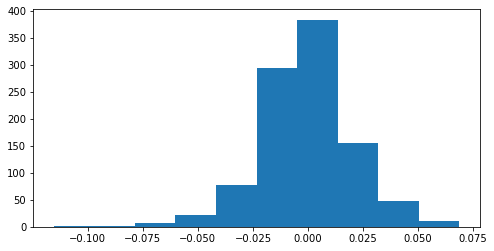

The standar error of the hedge is: 0.021192512682067247
The mean error of the hedge is: -0.001054449688037834


In [15]:
# Calculating the Delta-hedge in the BS-model
# Blackscholes price formula
def BS(S0, strike, T, sigma):
    d1 = (np.log(S0/strike)+0.5*T*sigma**2)/(np.sqrt(T)*sigma)
    d2 = d1 - sigma*np.sqrt(T)
    return S0*scipy.norm.cdf(d1) - strike*scipy.norm.cdf(d2)

testpaths = path(S0, mu,sigma, N, T, Ktest) # P-dynamics
priceBS = BS(S0, strike, T, sigma)
hedge = np.zeros(Ktest)
price = testpaths
for k in range(N):
    d1 = (np.log(price[k,:]/strike) + 0.5*(T - k*T/N)*sigma**2)/(np.sqrt(T - k*T/N)*sigma)
    hedge[:] = hedge[:] + scipy.norm.cdf(d1)*(price[k+1,:] - price[k,:])
hedge[:] = hedge[:] - 0.5*(np.abs(price[N,:] - strike) + (price[N,:] - strike)) + priceBS
print("Performance of discretised BS-delta-hedge inside BS-model. There is only discretisation error here.")
plt.rcParams['figure.figsize'] = [8, 4]
plt.hist(hedge)
plt.show()
print("The standar error of the hedge is:", np.std(hedge))
print("The mean error of the hedge is:",np.mean(hedge))


#### i) Tangens hyperbolicus: Model Evaluation

[Below]: Performance of learned hedge in the model (out of sample).


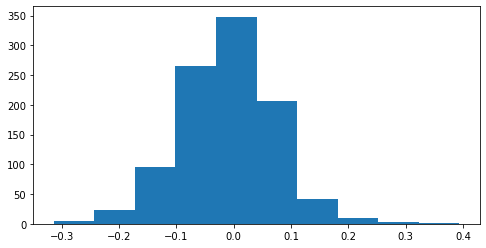

The standar error of the learned hedge is: 0.08301117
The mean error of the hedge is: -0.010251249


In [16]:
## Building test pathes to input architecture
xtest = []
for i in range(N+1):
    xtest = xtest + [testpaths[i,:]]

print("[Below]: Performance of learned hedge in the model (out of sample).")
plt.rcParams['figure.figsize'] = [8, 4]
plt.hist(model_hedge.predict(xtest))
plt.show()
print("The standar error of the learned hedge is:", np.std(model_hedge.predict(xtest)))
print("The mean error of the hedge is:", np.mean(model_hedge.predict(xtest)))

#### ii) Rectified linear unit

Now, we compare the results of our network for the case of a rectified linear unit (relu) activation Function.

In [18]:
activator = "relu"
model_hedge = Deephedge(activator, a)
model_hedge.compile(optimizer='adam',loss='mean_squared_error')
model_hedge.fit(x=xtrain,y=ytrain, epochs=epochs,verbose=True,batch_size=100)

Epoch 1/15
200/200 [==============================] - 2s 3ms/step - loss: 15.8180
Epoch 2/15
200/200 [==============================] - 1s 3ms/step - loss: 0.2541
Epoch 3/15
200/200 [==============================] - 1s 3ms/step - loss: 0.1037
Epoch 4/15
200/200 [==============================] - 1s 3ms/step - loss: 0.0587
Epoch 5/15
200/200 [==============================] - 1s 3ms/step - loss: 0.0461
Epoch 6/15
200/200 [==============================] - 1s 3ms/step - loss: 0.0411
Epoch 7/15
200/200 [==============================] - 1s 3ms/step - loss: 0.0380
Epoch 8/15
200/200 [==============================] - 1s 3ms/step - loss: 0.0357
Epoch 9/15
200/200 [==============================] - 1s 3ms/step - loss: 0.0340
Epoch 10/15
200/200 [==============================] - 1s 3ms/step - loss: 0.0325
Epoch 11/15
200/200 [==============================] - 1s 3ms/step - loss: 0.0310
Epoch 12/15
200/200 [==============================] - 1s 3ms/step - loss: 0.0299
Epoch 13/15
200/200 [===

#### ii) Rectified linear unit: Model Evaluation

[Below]: Performance of learned hedge in the model (out of sample).


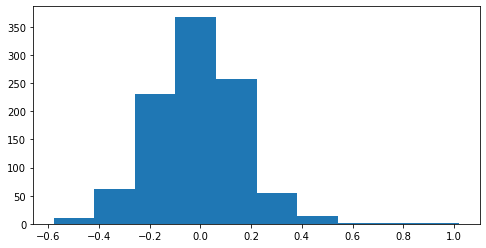

The standar error of the learned hedge is: 0.17233132
The mean error of the hedge is: -0.013660057


In [19]:
print("[Below]: Performance of learned hedge in the model (out of sample).")
plt.rcParams['figure.figsize'] = [8, 4]
plt.hist(model_hedge.predict(xtest))
plt.show()
print("The standar error of the learned hedge is:", np.std(model_hedge.predict(xtest)))
print("The mean error of the hedge is:", np.mean(model_hedge.predict(xtest)))

#### iii) Comparative of activation functions

From the previous analysis we can see that with the *relu* function we get a slightly worse approximation for the optimum strategy. Hence, in the following, we will be working with the tangens hyperbolicus activation function.


### Redo the training and testing for various values of $a$ and explain the effect of low/high transaction costs on the nature of the trading strategy and its performance.

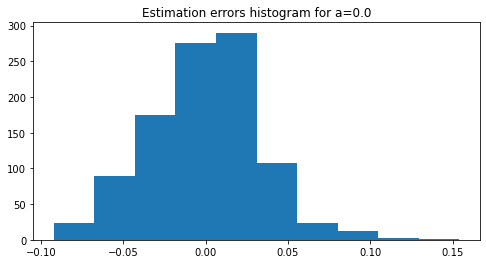

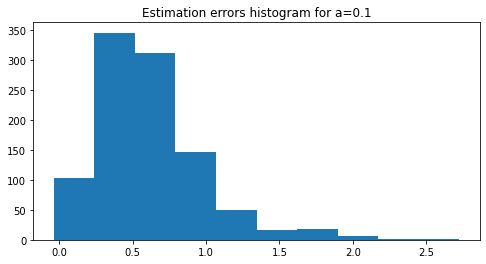

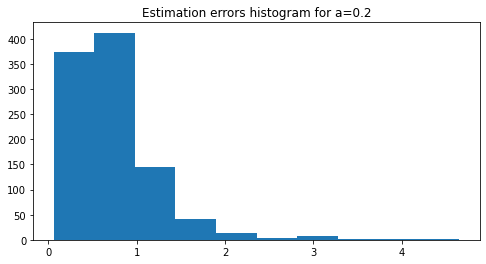

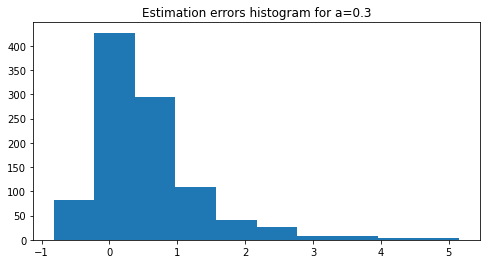

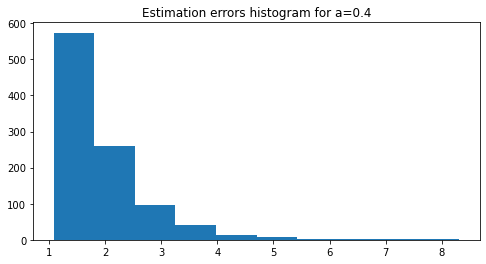

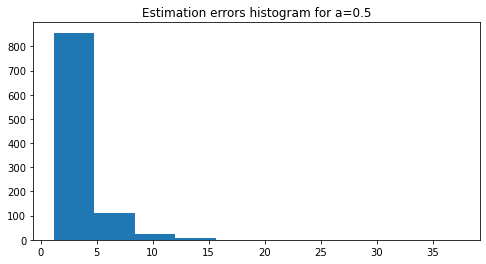

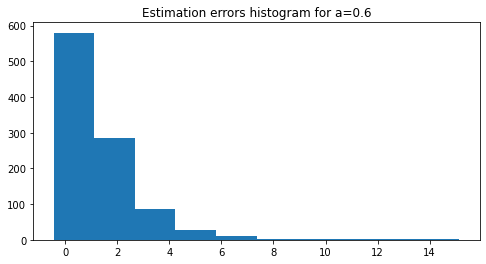

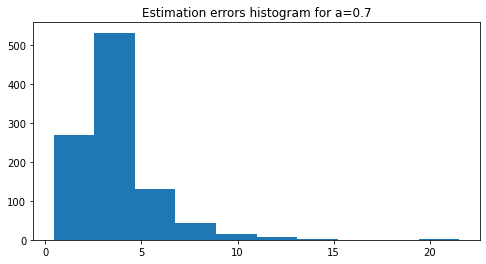

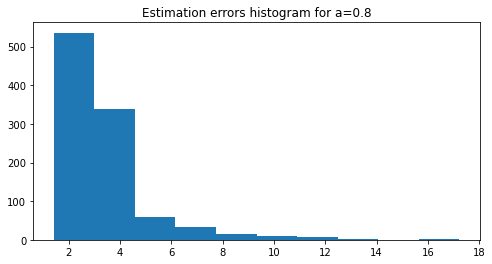

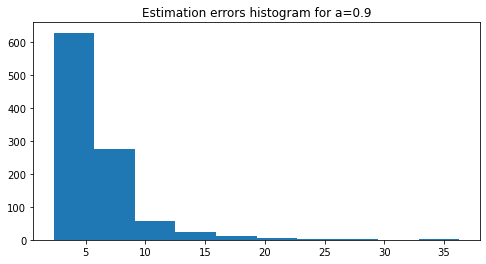

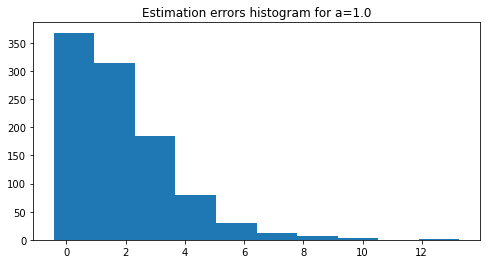

In [20]:
a = np.linspace(0, 1, 11)
activator = "tanh"
epochs = 15
ytrain = np.zeros((Ktrain, 1))
Mod_errs = pd.DataFrame({'a \ Statistic': ['mean', 'std dev', 'min', 'median', 'max']})

for j in range(len(a)):
    trainpaths = path(S0, mu, sigma, N, T, Ktrain) # P-dynamics
    
    xtrain = []
    for i in range(N+1):
        xtrain = xtrain + [trainpaths[i,:]]

    model_hedge = Deephedge(activator, a[j])

    model_hedge.compile(optimizer='adam',loss='mean_squared_error')
    model_hedge.fit(x=xtrain,y=ytrain, epochs=epochs,verbose=False,batch_size=100)
    
    testpaths = path(S0, mu,sigma, N, T, Ktest) # P-dynamics
    
    ## Building test pathes to input architecture
    xtest = []
    for i in range(N+1):
        xtest = xtest + [testpaths[i,:]]

    errs = model_hedge.predict(xtest)
    plt.hist(errs)
    plt.title('Estimation errors histogram for a=' + str(a[j].round(2)))
    plt.show()
    
    Mod_errs = pd.concat([Mod_errs, pd.DataFrame({str(a[j].round(2)): [np.mean(errs), np.std(errs), 
                                            min(errs)[0], statistics.median(errs)[0], max(errs)[0]]})], axis=1)
    
#Mod_errs.transpose()

In [21]:
Mod_errs.transpose()

,0,1,2,3,4
a \ Statistic,mean,std dev,min,median,max
0.0,-0.000593,0.033728,-0.092281,0.00165,0.154054
0.1,0.61493,0.368564,-0.039588,0.548497,2.727392
0.2,0.724988,0.519058,0.060368,0.616793,4.65323
0.3,0.544612,0.785444,-0.82214,0.358013,5.158203
0.4,1.975308,0.809765,1.080528,1.715723,8.315567
0.5,3.478553,2.210097,1.163199,2.888054,37.397945
0.6,1.279548,1.581586,-0.445068,0.838827,15.141623
0.7,3.721956,2.041835,0.433204,3.28761,21.537384
0.8,3.381874,1.67382,1.410173,2.910414,17.22842


#### Effects of $a$ in trading strategies and performance

From the previous table, we can see that we get the best approximated strategy if we don't include costs in the model, i.e., if $a=0$. On the other side, if we include them, as the value of $a$ increases, the approximation gets worse and apparently the strategies are underestimating the payoff of the call (payoff > wealth), that why we get so many positive errors.